In [1]:
import parallelPermutationTest as ppt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plots import timePlotSNS
import time

### Get synthetic data

In [2]:
%load_ext cython
%load_ext rpy2.ipython


In [3]:
%%capture
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

In [4]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [5]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [6]:
n_samples = 5
n = m =  500
bins =  [50, 100, 200,250,300,350,400,450,500]
data_variables = (n, n_samples, bins)

In [7]:
data = lambda n,n_samples : [np.random.randint(0,n,n,dtype=np.int32) for _ in range(n_samples)]

In [8]:
def runExperiment(method_list, names_list, data, data_variables):
    
    n, n_samples, bins = data_variables
    
    method_dict = dict()
    
    for method, name in zip(method_list, names_list):
        method_dict[name] = dict()
        method_dict[name]["p_values"] = list()
        method_dict[name]["time"] = list()
        for i in range(n_samples):
            
            np.random.seed(i)
            
            for b in bins:
                
                A = np.asarray(data(n, 1))
                B = np.asarray(data(n, 1))
        
                start = time.time()
                method_dict[name]["p_values"].append(method(A,B,b)[0])
                end = time.time()
                method_dict[name]["time"].append(end - start)
    return method_dict
    

In [9]:
method_list = [ppt.GreenFloat, ppt.GreenFloatMultiThread, ppt.GreenFloatCuda, ppt.CoinShiftFloat]
names_list = ["GreenFloat", "GreenFloatMultiThread", "GreenFloatCuda", "CoinShiftFloat"]
method_dict = runExperiment(method_list, names_list, data, data_variables)
    


In [10]:
np.allclose(np.asarray(method_dict["GreenFloat"]["p_values"]),
                np.asarray(method_dict["GreenFloatMultiThread"]["p_values"]),
                np.asarray(method_dict["GreenFloatCuda"]["p_values"]),
                np.asarray(method_dict["CoinShiftFloat"]["p_values"]))
             
    

True

In [11]:
TimeList_list = [method_dict["GreenFloat"]["time"], 
                 method_dict["GreenFloatMultiThread"]["time"],
                 method_dict["GreenFloatCuda"]["time"],
                 method_dict["CoinShiftFloat"]["time"]]
NameList = ["Green Singlethread", "Green Multithread", "Green Cuda", "Coin Shift"]

In [12]:
rep_bins = bins * n_samples

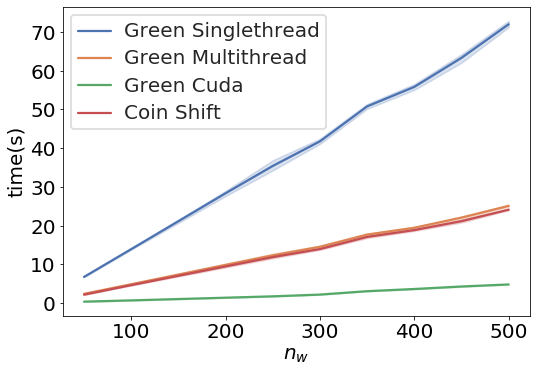

In [13]:
timePlotSNS(TimeList_list, NameList, rep_bins, 'time(s)',  r"$n_{w}$", log=False, path="./figures/experiment1/TimeVsbins_linear")


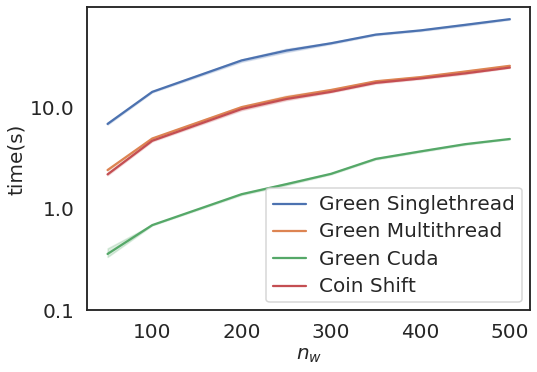

In [14]:
timePlotSNS(TimeList_list, NameList, rep_bins, 'time(s)',  r"$n_{w}$", log=True, path="./figures/experiment1/TimeVsbins_log")

Add FastPerm function

In [15]:
n_samples = 5
N_list = [50, 100, 200,250,300,350,400,450,500]
data_variables = (N_list, n_samples)

In [16]:
rep_N = N_list * n_samples

In [17]:
data = lambda n,n_samples : [np.random.randint(0,n,n,dtype=np.int32) for _ in range(n_samples)]

In [18]:
def runExperiment(method_list, names_list, data, data_variables):
    
    N_list, n_samples = data_variables
    
    method_dict = dict()
    
    for method, name in zip(method_list, names_list):
        method_dict[name] = dict()
        method_dict[name]["p_values"] = list()
        method_dict[name]["time"] = list()
        for i in range(n_samples):
            
            np.random.seed(i)
            
            for n in N_list:
                
                A = np.asarray(data(n, 1))
                B = np.asarray(data(n, 1))
        
                start = time.time()
                method_dict[name]["p_values"].append(method(A,B)[0])
                end = time.time()
                method_dict[name]["time"].append(end - start)
    return method_dict
    

In [19]:
method_list = [ppt.GreenInt, ppt.GreenIntMultiThread, ppt.GreenIntCuda, ppt.CoinShiftInt, fastPerm]
names_list = ["GreenInt", "GreenIntMultiThread", "GreenIntCuda", "CoinShiftInt", "fastPerm"]
method_dict = runExperiment(method_list, names_list, data, data_variables)
    

In [20]:
TimeList_list_N = [method_dict["GreenInt"]["time"], 
                 method_dict["GreenIntMultiThread"]["time"],
                 method_dict["GreenIntCuda"]["time"],
                 method_dict["CoinShiftInt"]["time"],
                 method_dict["fastPerm"]["time"]]
NameList_N = ["Green Singlethread", "Green Multithread", "Green Cuda", "Coin Shift", "fastPerm"]

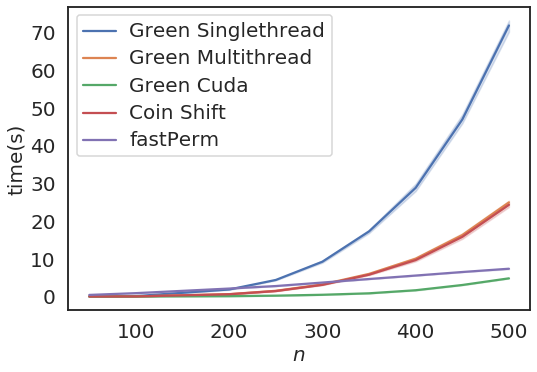

In [21]:
timePlotSNS(TimeList_list_N, NameList_N, rep_N, 'time(s)',  r"$n$", log=False, path="./figures/experiment1/TimeVSetSize_linear")


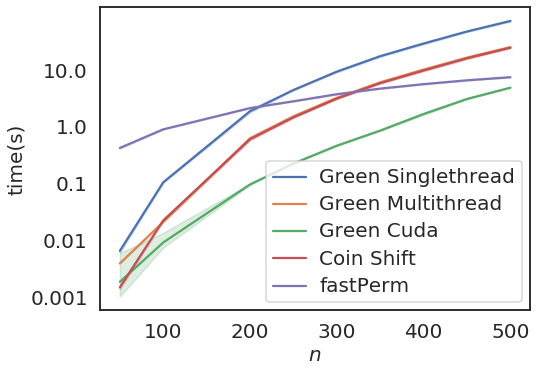

In [22]:
timePlotSNS(TimeList_list_N, NameList_N, rep_N, 'time(s)',  r"$n$", log=True, path="./figures/experiment1/TimeVSetSize_log")